## VGG Block

定义 VGG 块

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def vgg_block(num_convs, in_channels, out_channels):
    """
    定义一个 vgg 块
    :param num_convs: vgg 块中的 卷积层数量
    :param in_channels: 当前 vgg 块的输入通道数量
    :param out_channels: 当前 vgg 块的输出通道数量
    :return: 
    """
    layers = []
    for _ in range(num_convs):
        """第一层卷积的输入通道数量是 vgg 块的输入通道数
        第二层开始卷积的输入通道数量等于第一层卷积的
        """
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

## 构造 缩小版的 VGG-11 网络

输入的图片形状是 224, 224

数据的形状是 批量大小, 通道数, 图像高, 宽

In [2]:
# (卷积层数量, 输出通道数量)
ratio = 4
conv_arch = ((1, 64 // ratio), (1, 128 // ratio), (2, 256 // ratio), (2, 512 // ratio), (2, 512 // ratio))

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1  # 第一个 vgg 块的输入通道为 1

    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        # 第二个VGG块开始的输入通道数量等于上一个VGG块的输出通道数量
        in_channels = out_channels  
    
    # 全连接部分
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分; 
        # output_channels * 7 * 7 是因为最后一层 vgg 块的图像高, 宽 是 7, 7
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

## 测试网络结构

In [3]:
# 批量大小, 通道数, 图像高, 宽
X = torch.rand(1, 1, 224, 224)
X.shape

torch.Size([1, 1, 224, 224])

In [4]:
inputs = X
for layer in net:
    inputs = layer(inputs)
    print(f'{layer.__class__.__name__} output shape is {inputs.shape}')

Sequential output shape is torch.Size([1, 16, 112, 112])
Sequential output shape is torch.Size([1, 32, 56, 56])
Sequential output shape is torch.Size([1, 64, 28, 28])
Sequential output shape is torch.Size([1, 128, 14, 14])
Sequential output shape is torch.Size([1, 128, 7, 7])
Flatten output shape is torch.Size([1, 6272])
Linear output shape is torch.Size([1, 4096])
ReLU output shape is torch.Size([1, 4096])
Dropout output shape is torch.Size([1, 4096])
Linear output shape is torch.Size([1, 4096])
ReLU output shape is torch.Size([1, 4096])
Dropout output shape is torch.Size([1, 4096])
Linear output shape is torch.Size([1, 10])


## 评价函数

In [5]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度。"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            # d2l.accuracy(net(X), y) 计算正确预测的个数
            # y.numel() 返回张量中元素的个数
            metric.add(d2l.accuracy(net(X), y), y.numel())
    # 正确预测的个数 / 总数
    return metric[0] / metric[1]

## 训练函数

In [6]:
#@save
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)。"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))

        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

## 加载 fashion mnist 数据集

In [7]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=128, resize=224)

## 训练模型

loss 0.176, train acc 0.934, test acc 0.918
2829.4 examples/sec on cuda:1


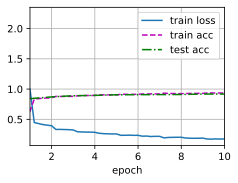

In [8]:
device = torch.device('cuda:1')
lr, num_epochs = 0.05, 10
net.to(device)
train_ch6(net, train_iter, test_iter, num_epochs, lr, device)